<div style="text-align: center; font-size: 40px;">
    <strong>Credit Data Analysis</strong>
</div>


## **Introduction**
- This analysis explores a comprehensive consumer loan dataset that combines credit bureau information with loan application data to understand factors influencing loan defaults. The dataset comprises 41 features covering essential aspects of credit assessment, including credit scores, account histories, identity verification statuses, and loan-specific details.
- The data encompasses three main categories:
     - **Credit Bureau Information:** Including credit scores, account histories, and payment behaviors
     - **Loan Details:** Covering disbursement amounts, asset costs, and loan-to-value ratios
     - **Borrower Information:** Containing verification statuses, employment type, and geographical indicators


- Through this exploratory analysis, we aim to uncover significant patterns and relationships between these variables and loan default outcomes. The insights derived will be valuable for improving risk assessment methodologies and lending decisions while maintaining responsible lending practices.

### **Importing the Libraries**


In [18]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

### **DB Connection Function**

Acts as the bridge for connecting to the database and executing queries.


In [19]:
def get_alchemy_engine():
    """
    Creates and returns an SQLAlchemy engine using the database settings.
    """
    db_settings = {
        "ENGINE": "django.db.backends.postgresql",  # Database engine
        
        "NAME": "cibilDB",                         # Database name
        "USER": "postgres",                        # Username
        "PASSWORD": "password@123",                # Password with special characters
        "HOST": "localhost",                       # Host address
        "PORT": "5432",                            # Port
    }
    
    # URL-encode the password to handle special characters
    encoded_password = quote_plus(db_settings['PASSWORD'])
    
    # Construct the SQLAlchemy connection URL
    connection_url = (
        f"postgresql://{db_settings['USER']}:{encoded_password}@"
        f"{db_settings['HOST']}:{db_settings['PORT']}/{db_settings['NAME']}"
    )
    
    # Create and return the SQLAlchemy engine
    engine = create_engine(connection_url)
    return engine

def fetch_data(query):
    """
    Fetches data from the PostgreSQL database using Pandas.
    :param query: SQL query string
    :return: Pandas DataFrame with query results
    """
    engine = get_alchemy_engine()
    
    # Use Pandas to execute the query and fetch data into a DataFrame
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)

    if engine:
        engine.dispose()
        # print("Engine connection closed.")
        
    return df

## **Data Feature Description**
For the dataset considered in the analysis following is the detailed overview for the same, representing important info for each feature.
                                                                                                                       

In [20]:
descQuery = '''
    SELECT
        UPPER(column_name) AS "Feature Name",
        UPPER(data_type) AS "Feature Type",
        CASE 
            WHEN data_type IN ('character varying', 'text') THEN 'VARCHAR'
            WHEN data_type IN ('integer', 'bigint', 'smallint') THEN 'INTEGER'
            WHEN data_type = 'date' THEN 'DATE'
            ELSE data_type
        END AS "Feature DTYPE",
        (SELECT COUNT(*) 
         FROM "master-cibil-data" 
         WHERE column_name IS NULL OR column_name = '') AS "Total Null Values"
    FROM
        information_schema.columns
    WHERE
        table_name = 'master-cibil-data';
'''
data = fetch_data(descQuery)
data  

,Feature Name,Feature Type,Feature DTYPE,Total Null Values
0,LOAN_DEFAULT,INTEGER,INTEGER,0
1,DISBURSED_AMOUNT,INTEGER,INTEGER,0
2,ASSET_COST,INTEGER,INTEGER,0
3,LTV,REAL,real,0
4,BRANCH_ID,INTEGER,INTEGER,0
5,SUPPLIER_ID,INTEGER,INTEGER,0
6,MANUFACTURER_ID,INTEGER,INTEGER,0
7,CURRENT_PINCODE_ID,INTEGER,INTEGER,0
8,PRIMARY_INSTAL_AMT,INTEGER,INTEGER,0
9,SEC_INSTAL_AMT,INTEGER,INTEGER,0


In [21]:
def plotTwoCharts(df, chartParams):
    # print(df.columns)
    """
    Function to plot two charts side by side with different chart types (line, scatter, bar, pie, histogram).
    Parameters:
    df (DataFrame): The dataframe containing the data
    chartParams (dict): Dictionary containing chart details
    """
    totalCharts = len(chartParams['chartData'])
    rows = (totalCharts + 1) // 2  # Calculate rows for the fixed 2-column layout

    # Create subplots
    fig, axes = plt.subplots(rows, 2, figsize=(13, 5 * rows))
    axes = axes.flatten()  # Flatten to simplify indexing

    for chart in range(totalCharts):
        chartDetails = chartParams['chartData'][chart]
        chartType = chartDetails['type']
        xvalue = chartDetails['xCol']
        yvalues = chartDetails.get('yCol', [])
        lvalue = chartDetails.get('legend', None)  # Use .get to handle optional keys

        sns.set_style("darkgrid")
        if chartType == 'line':
            if lvalue:  # If 'legend' is specified, restructure the data for grouped plotting
                plot_df = pd.melt(
                    df, 
                    id_vars=[xvalue], 
                    value_vars=yvalues, 
                    var_name='Group', 
                    value_name='Value'
                )
                plot_df['Group'] = plot_df['Group'].replace(dict(zip(yvalues, lvalue)))
                sns.lineplot(
                    data=plot_df,
                    x=xvalue,
                    y='Value',
                    hue='Group',
                    marker='o',
                    ax=axes[chart]
                )
            else:  # Simple line plot
                for col in yvalues:
                    sns.lineplot(
                        data=df,
                        x=xvalue,
                        y=col,
                        marker='o',
                        ax=axes[chart]
                    )
        elif chartType == 'scatter':
            sns.scatterplot(data=df, x=xvalue, y=yvalues[0], hue=lvalue, ax=axes[chart])
        elif chartType == 'bar':
            if len(yvalues) > 1 and lvalue:
                    melted_df = pd.melt(
                        df,
                        id_vars=[xvalue],
                        value_vars=yvalues,
                        var_name='Group',
                        value_name='Value'
                    )
                    melted_df['Group'] = melted_df['Group'].replace(
                        dict(zip(yvalues, lvalue))
                    )
                    sns.barplot(
                        data=melted_df,
                        x=xvalue,
                        y='Value',
                        hue='Group',
                        palette="Set2",
                        ax=axes[chart]
                    )
            else:
                bars = sns.barplot(
                    data=df,
                    x=xvalue,
                    y=yvalues[0],
                    color="#66b3ff",
                    ax=axes[chart]
                )
                for bar in bars.patches:
                    height = bar.get_height()
                    bars.annotate(
                        f'{height:.1f}',
                        (bar.get_x() + bar.get_width() / 2, height),
                        ha='center',
                        va='bottom',
                        fontsize=9,
                        color='black'
                    )
        elif chartType == 'pie':
            # For pie chart: Use the first column in xCol as categories
            # Enhanced Pie Chart Code
            pie_data = df[xvalue].value_counts()
            
            # Create the pie chart
            wedges, texts, autotexts = axes[chart].pie(
                pie_data,
                autopct='%1.1f%%', 
                startangle=90, 
                labels=pie_data.index, 
                colors=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'],  # Custom color palette
                textprops={'fontsize': 10, 'color': 'black'}  # Text properties for better readability
            )
            
            # Style the percentage labels
            for autotext in autotexts:
                autotext.set_fontsize(12)
                autotext.set_fontweight('bold')
            
            # Set title with better styling
            axes[chart].set_title(
                "Loan Default Distribution".upper(),
                fontsize=14,
                fontweight='bold',
                pad=20
            )
            
            # Remove y-axis label
            axes[chart].set_ylabel("")
            
            # Add a legend outside the chart
            axes[chart].legend(
                pie_data.index,
                title="Categories",
                loc="upper right",
                bbox_to_anchor=(1.2, 0.9),  # Position outside the chart
                fontsize=10
            )

        elif chartType == 'histogram':
            sns.histplot(data=df, x=xvalue, bins=20, kde=True, ax=axes[chart])

        axes[chart].set_title(chartDetails['chartTitle'].upper(), fontsize=12)
        axes[chart].set_xlabel(xvalue.upper(), fontsize=10)
        axes[chart].set_ylabel(', '.join(yvalues), fontsize=10)
        axes[chart].tick_params(axis='both', which='major', labelsize=10)

    # Hide any unused axes
    for ax in axes[totalCharts:]:
        ax.set_visible(False)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## **Exploratory Data Analysis**

In [22]:
targetQuery = '''
 SELECT 
 	CASE WHEN "LOAN_DEFAULT" = 1 THEN 'DEFAULT' ELSE 'NO-DEFAULT' END  AS loanDefault
 FROM 
     "master-cibil-data" mcd 
'''
data = fetch_data(targetQuery)
data  

,loandefault
0,NO-DEFAULT
1,DEFAULT
2,NO-DEFAULT
3,DEFAULT
4,DEFAULT
...,...
233149,NO-DEFAULT
233150,NO-DEFAULT
233151,NO-DEFAULT
233152,NO-DEFAULT


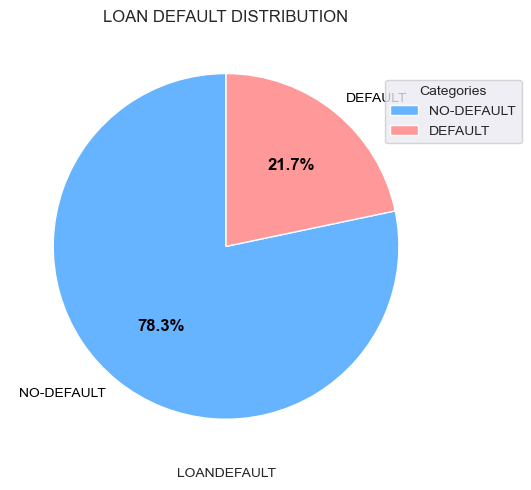

In [23]:
chartParams = {
    "chartData": [
        {
            "type": "pie",
            "xCol": "loandefault",  # Column containing categorical data
            "chartTitle": "Loan Default Distribution"
        }
    ]
}

plotTwoCharts(data, chartParams)

- **As visible the dataset seems to be imbalanced as the data is skewed towards data with no-default result.**

Index(['age_group', 'EMPLOYMENT_TYPE'], dtype='object')


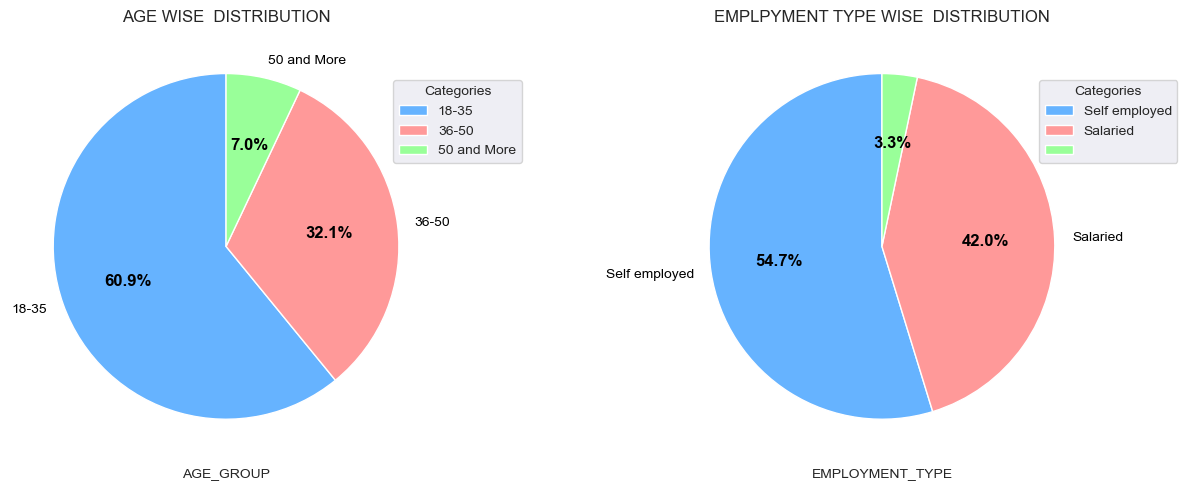

In [24]:
targetQuery = '''
    SELECT 
        CASE 
            WHEN p.age BETWEEN 18 AND 35 THEN '18-35' 
            WHEN p.age BETWEEN 36 AND 50 THEN '36-50' 
            WHEN p.age > 50 THEN '50 and More' 
            ELSE 'Below 18' 
        END AS age_group,
        "EMPLOYMENT_TYPE"
    FROM 
        (
        SELECT 
            DATE_PART('year', AGE(CAST("DISBURSAL_DATE" AS DATE), CAST("DATE_OF_BIRTH" AS DATE))) AS age  ,
            "EMPLOYMENT_TYPE"
        FROM 
            "master-cibil-data" mcd 
        ) AS p;

'''
data = fetch_data(targetQuery)
print(data.columns)

chartParams = {
    "chartData": [
        {
            "type": "pie",
            "xCol": "age_group",  # Column containing categorical data
            "chartTitle": "Age wise  Distribution"
        },
        {
            "type": "pie",
            "xCol": "EMPLOYMENT_TYPE",  # Column containing categorical data
            "chartTitle": "Emplpyment type wise  Distribution"
        },
        
    ]
}

plotTwoCharts(data, chartParams)

- **The age-wise distribution of individuals in three categories: 18-35 (60.9%), 36-50 (32.1%), and 50 and More (7.0%). The majority of individuals fall into the 18-35 age group, indicating a younger demographic.**

- **The employment type distribution among individuals: 54.7% are self-employed, 42.0% are salaried, and 3.3% fall into other categories. The majority are self-employed, making up over half of the total.**

In [25]:
targetQuery = '''

    SELECT 
        "PERFORM_CNS_SCORE_DESCRIPTION",
        COUNT(*) AS totalEntry,
        SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
        SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
        ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM 
        "master-cibil-data" mcd 
    GROUP BY 
        "PERFORM_CNS_SCORE_DESCRIPTION" 
    ORDER BY 
        totalEntry DESC;

'''
data = fetch_data(targetQuery)
data

,PERFORM_CNS_SCORE_DESCRIPTION,totalentry,loandefaulted,loannotdefaulted,loandefaultpercentage
0,No Bureau History Available,116950,27052.0,89898,23.13
1,C-Very Low Risk,16045,2770.0,13275,17.26
2,A-Very Low Risk,14124,2341.0,11783,16.57
3,D-Very Low Risk,11358,1699.0,9659,14.96
4,B-Very Low Risk,9201,1208.0,7993,13.13
5,M-Very High Risk,8776,2673.0,6103,30.46
6,F-Low Risk,8485,1580.0,6905,18.62
7,K-High Risk,8277,2302.0,5975,27.81
8,H-Medium Risk,6855,1658.0,5197,24.19
9,E-Low Risk,5821,1000.0,4821,17.18


- **High Risk Categories (M, K, J, L) have higher loan default percentages, particularly M-Very High Risk (30.46%), K-High Risk (27.81%), and L-Very High Risk (28.04%).**
- **Very Low Risk categories (e.g., A-Very Low Risk, B-Very Low Risk) have much lower default percentages, ranging from 13.13% to 16.57%.**
- **Other Scored Categories (e.g., Not Scored: Sufficient History Not Available) show higher default percentages like 25.58%.**
- **Several categories marked as "Not Scored" have specific situations such as inactivity, insufficient information, or guarantor status, which also show varied default rates.**

In [26]:
targetQuery = '''

    SELECT 
        "STATE_ID" ,
        SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
        SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
        ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM 
        "master-cibil-data" mcd 
    GROUP BY 
         "STATE_ID" 

'''
data = fetch_data(targetQuery)
data

,STATE_ID,loandefaulted,loannotdefaulted,loandefaultpercentage
0,1,1583,7353,17.71
1,2,1129,3031,27.14
2,3,6345,27733,18.62
3,4,9326,35544,20.78
4,5,2023,8154,19.88
5,6,6890,26615,20.56
6,7,1369,5417,20.17
7,8,3258,10939,22.95
8,9,3492,12530,21.80
9,10,633,2972,17.56


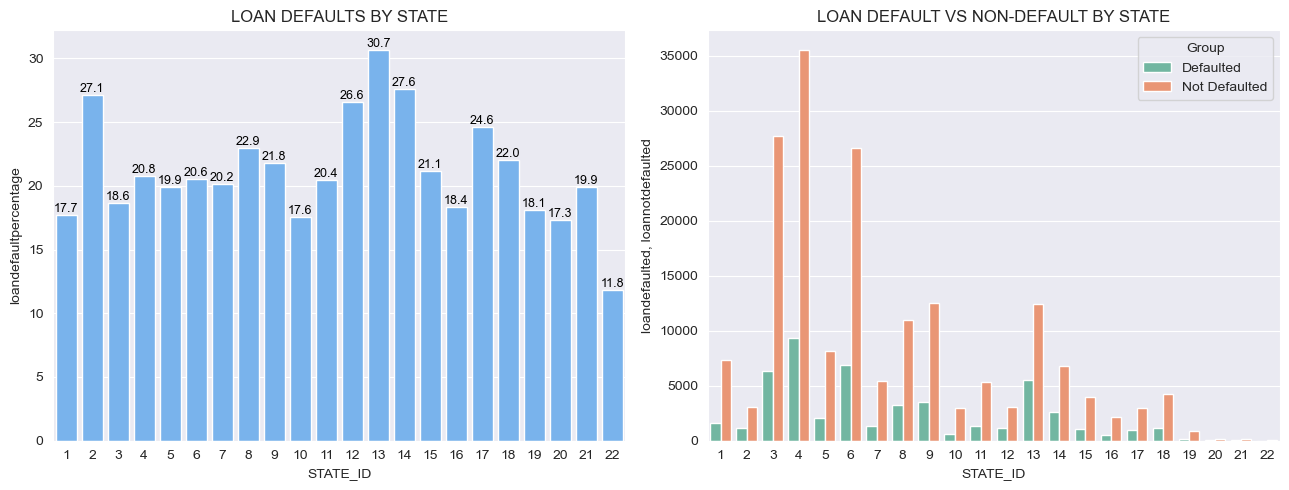

In [27]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "STATE_ID",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by State",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "STATE_ID",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by State",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

- **State_ID 12 has the highest default rate at 30.7%, over 50% higher than the next highest state.**
- **Default rates are above 20% in 5 states (12, 13, 10, 11, 14).**
- **The difference between defaulted and non-defaulted loans is largest in State_ID 12, with over 30,000 defaulted compared to under 5,000 non-defaulted.**
- **This disparity is consistent across many states, suggesting high-risk lending practices or economic conditions in certain regions.**

In [28]:
targetQuery = '''
    SELECT 
    	q.age_group,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
    	ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM (
    	SELECT 
    	    CASE 
    	        WHEN p.age BETWEEN 18 AND 35 THEN '18-35' 
    	        WHEN p.age BETWEEN 36 AND 50 THEN '36-50' 
    	        WHEN p.age > 50 THEN '50 and More' 
    	        ELSE 'Below 18' 
    	    END AS age_group,
    	    "LOAN_DEFAULT"
    	    FROM 
    	(
    	    SELECT 
    	        DATE_PART('year', AGE(CAST("DISBURSAL_DATE" AS DATE), CAST("DATE_OF_BIRTH" AS DATE))) AS age,
    	       	"LOAN_DEFAULT"
    	    FROM 
    	        "master-cibil-data" mcd 
    	) AS p
    ) AS q
    GROUP BY 
    	q.age_group
'''
data = fetch_data(targetQuery)
data

,age_group,loandefaulted,loannotdefaulted,loandefaultpercentage
0,18-35,32240,109757,22.70
1,50 and More,3125,13295,19.03
2,36-50,15246,59491,20.40


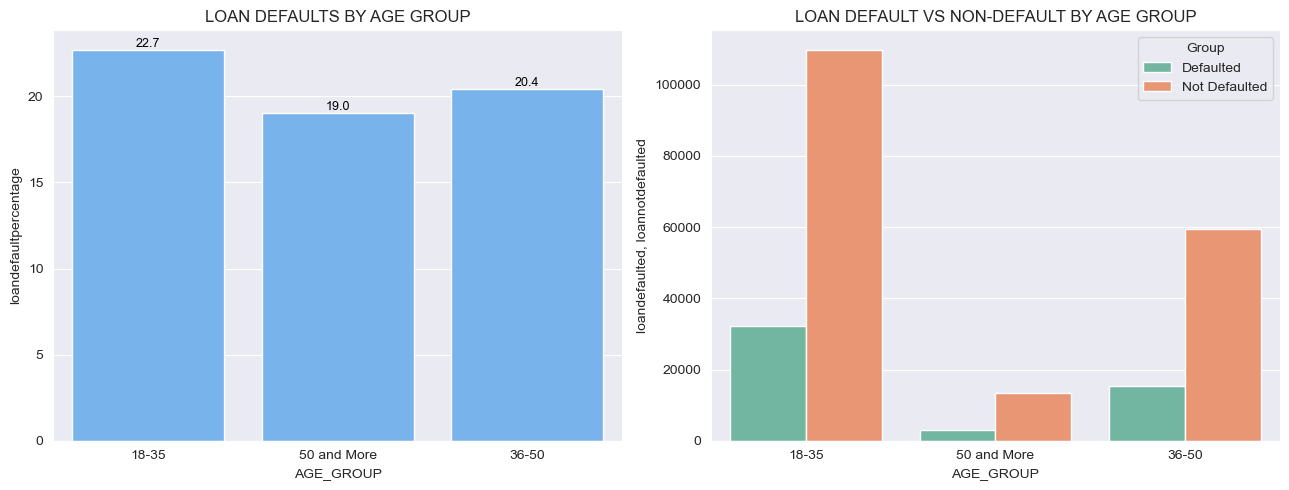

In [29]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "age_group",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by Age Group",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "age_group",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by Age Group",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

In [30]:
targetQuery = '''
    SELECT 
    	"EMPLOYMENT_TYPE" ,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
    	ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
	FROM 
    	"master-cibil-data" mcd 
	GROUP BY 
    	 "EMPLOYMENT_TYPE"
'''
data = fetch_data(targetQuery)
data

,EMPLOYMENT_TYPE,loandefaulted,loannotdefaulted,loandefaultpercentage
0,,1644,6017,21.46
1,Salaried,19910,77948,20.35
2,Self employed,29057,98578,22.77


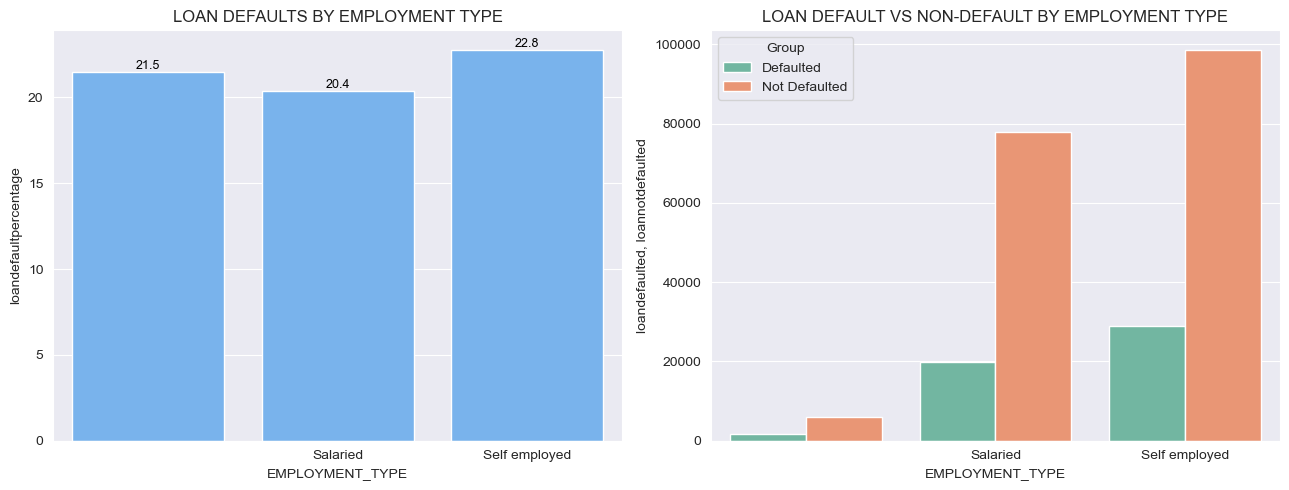

In [31]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "EMPLOYMENT_TYPE",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by EMPLOYMENT TYPE",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "EMPLOYMENT_TYPE",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by EMPLOYMENT TYPE",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

In [32]:
targetQuery = '''
    SELECT 
        EXTRACT(YEAR FROM "DISBURSAL_DATE"::DATE) AS year,
        SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 ELSE 0 END) AS loanDefaulted,
        SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 ELSE 0 END) AS loanNotDefaulted,
        ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM 
        "master-cibil-data" mcd 
    GROUP BY 
        EXTRACT(YEAR FROM "DISBURSAL_DATE"::DATE)
    ORDER BY 
        year;
'''
data = fetch_data(targetQuery)
data

,year,loandefaulted,loannotdefaulted,loandefaultpercentage
0,2018.0,50611,182543,21.71


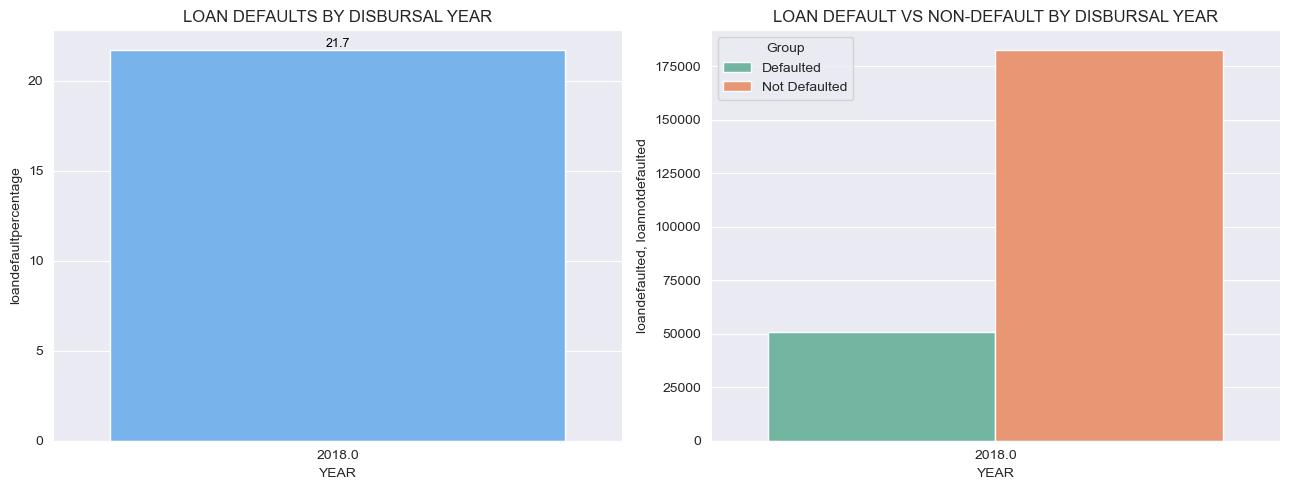

In [33]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "year",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by Disbursal Year",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "year",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by Disbursal Year",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

In [37]:
targetQuery = '''
    SELECT 
        ltvCategorization,
        SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
        SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
        ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM (
        SELECT 
            CASE 
                WHEN "LTV" < 69 THEN 'Q1'
                WHEN "LTV" BETWEEN 69 AND 77 THEN 'Q2'
                WHEN "LTV" BETWEEN 77 AND 83 THEN 'Q3'
                WHEN "LTV" > 83 THEN 'Q4'
            END AS ltvCategorization,
            "LOAN_DEFAULT" 
        FROM 
            "master-cibil-data" mcd 
    ) AS p 
    GROUP BY 
        p.ltvCategorization
    ORDER BY 
    	loanDefaultPercentage
'''
data = fetch_data(targetQuery)
data

,ltvcategorization,loandefaulted,loannotdefaulted,loandefaultpercentage
0,Q1,9202,49640,15.64
1,Q2,12337,46764,20.87
2,Q3,12217,39687,23.54
3,Q4,16855,46452,26.62


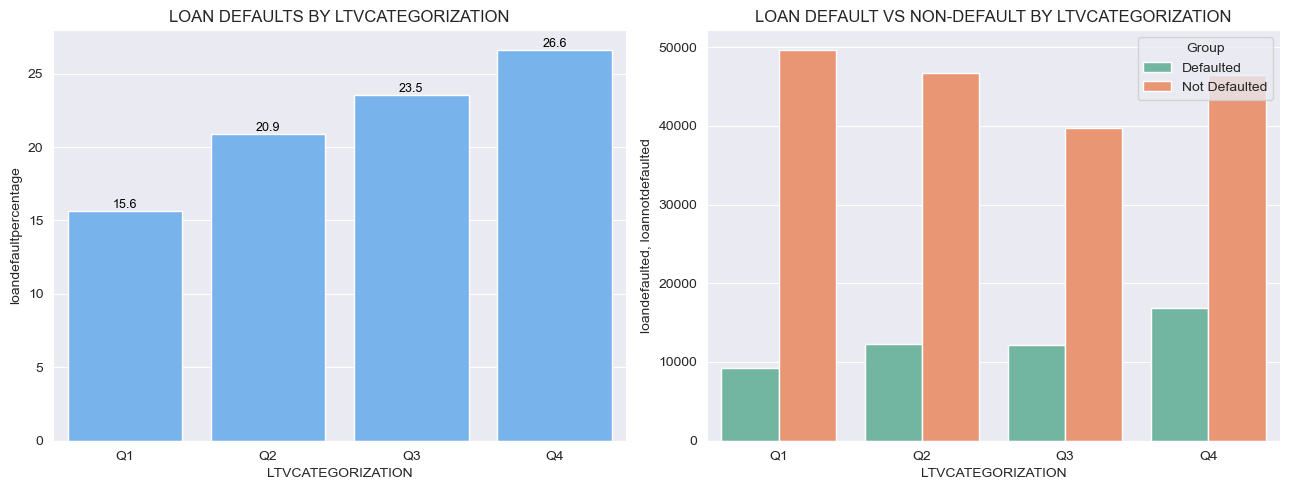

In [38]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "ltvcategorization",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by ltvcategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "ltvcategorization",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by ltvcategorization",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

- **Loan defaults peaked at 26.6% for the highest LTV categorization.**
- **Defaults increased across LTV categories from Q1 to Q4.**
- **Non-defaults remained relatively stable over the same period.**
- **Q4 saw the widest gap between defaulted and non-defaulted loans.**

In [39]:
targetQuery = '''
    SELECT 
    	accountAgeCategorization,
    	SUM("NO_OF_INQUIRIES") AS totalInquiries,
    	SUM("DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS") AS totalDeliquentAccount,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
    	ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM (
        SELECT 
            CASE 
            	WHEN Average_Account_Years < 1 THEN '< 1'
            	ELSE '>= 1'
            END AS accountAgeCategorization,
            "NO_OF_INQUIRIES" ,
            "DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS" ,
            "LOAN_DEFAULT" 
        FROM (
        
            SELECT 
                CAST(SUBSTRING("AVERAGE_ACCT_AGE", 1, POSITION('yrs' IN "AVERAGE_ACCT_AGE") - 1) AS INTEGER) AS Average_Account_Years,
                "NO_OF_INQUIRIES" ,
                "DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS" ,
                "LOAN_DEFAULT" 	
            FROM 
                "master-cibil-data" mcd 
        ) AS p 
    ) AS q
    GROUP BY 
    accountAgeCategorization
'''
data = fetch_data(targetQuery)
data

,accountagecategorization,totalinquiries,totaldeliquentaccount,loandefaulted,loannotdefaulted,loandefaultpercentage
0,< 1,32024,7513,37520,130870,22.28
1,>= 1,16149,15215,13091,51673,20.21


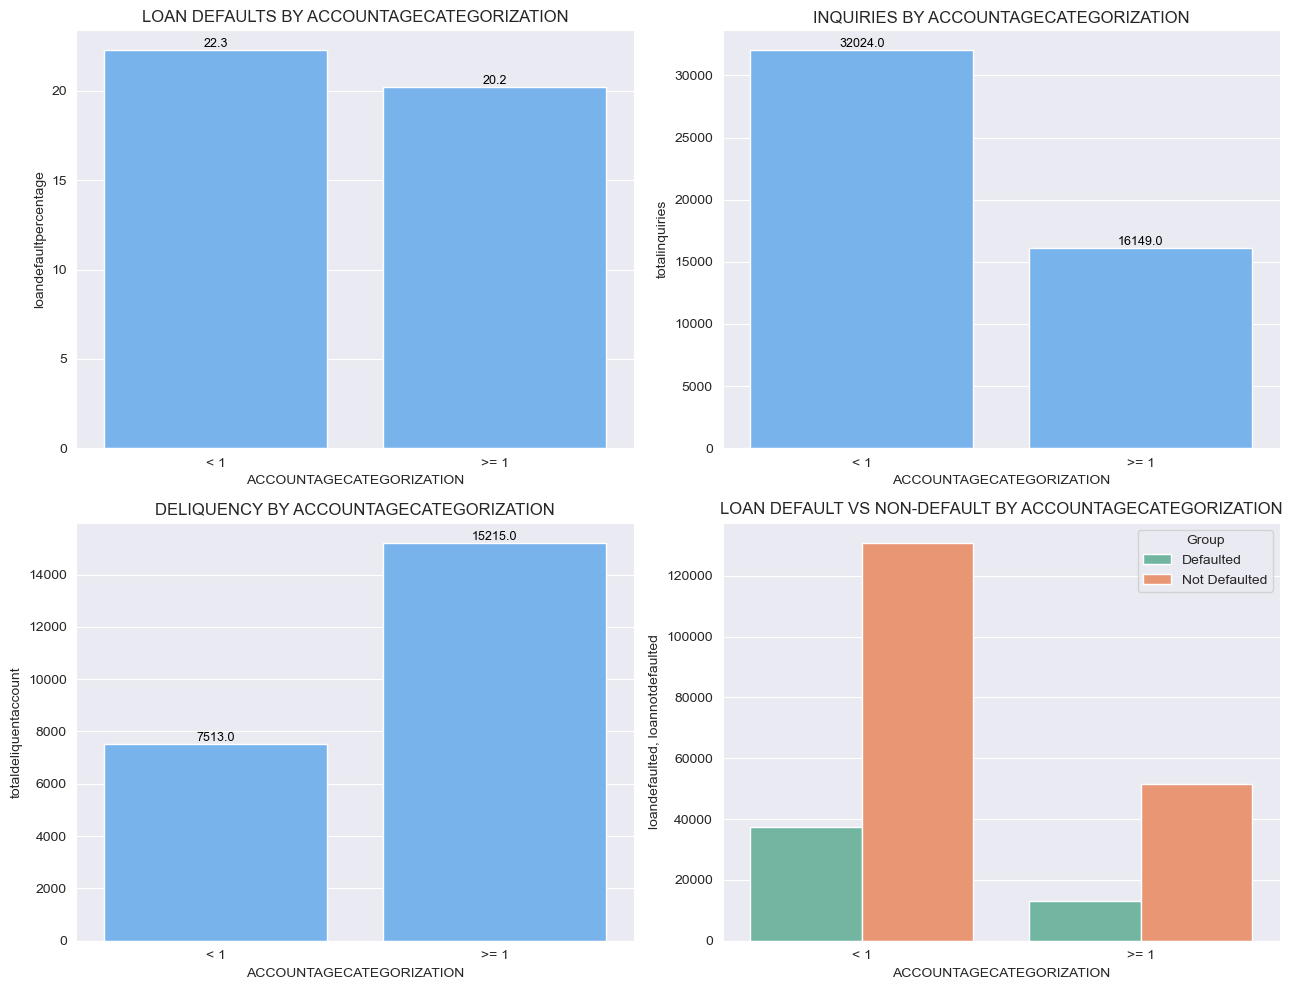

In [41]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "accountagecategorization",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by accountagecategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Simple bar chart
            "xCol": "accountagecategorization",  # States as the x-axis
            "yCol": ["totalinquiries"],  # Loan defaults as the y-axis
            "chartTitle": "Inquiries by accountagecategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Simple bar chart
            "xCol": "accountagecategorization",  # States as the x-axis
            "yCol": ["totaldeliquentaccount"],  # Loan defaults as the y-axis
            "chartTitle": "Deliquency by accountagecategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "accountagecategorization",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by accountagecategorization",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

### **Account Age Categorization:**

- **Default Rate:** Higher default percentage for < 1 year of account age (22.28%) vs. >= 1 year (20.21%).
- **Inquiries:** More loan inquiries for < 1 year (32,024) than >= 1 year (16,149).
- **Delinquent Accounts:** More delinquent accounts for >= 1 year (15,215) than < 1 year (7,513).

In [42]:
targetQuery = '''
    SELECT 
    	creditHistoryCategorization,
    	SUM("NO_OF_INQUIRIES") AS totalInquiries,
    	SUM("DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS") AS totalDeliquentAccount,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) AS loanDefaulted,
    	SUM(CASE WHEN "LOAN_DEFAULT" = 0 THEN 1 END) AS loanNotDefaulted,
    	ROUND((SUM(CASE WHEN "LOAN_DEFAULT" = 1 THEN 1 END) * 100.0) / COUNT(*), 2) AS loanDefaultPercentage
    FROM (
        SELECT 
            CASE 
            	WHEN Credit_History_Years < 2 THEN '< 2'
            	ELSE '>= 2'
            END AS creditHistoryCategorization,
            "NO_OF_INQUIRIES" ,
            "DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS" ,
            "LOAN_DEFAULT" 
        FROM (

                SELECT 
                    CAST(SUBSTRING("CREDIT_HISTORY_LENGTH", 1, POSITION('yrs' IN "CREDIT_HISTORY_LENGTH") - 1) AS INTEGER) AS Credit_History_Years,
                    "NO_OF_INQUIRIES" ,
                    "DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS" ,
                    "LOAN_DEFAULT" 	
                FROM 
                    "master-cibil-data" mcd 
            ) AS p 
        ) AS q
    GROUP BY 
        creditHistoryCategorization
'''
data = fetch_data(targetQuery)
data

,credithistorycategorization,totalinquiries,totaldeliquentaccount,loandefaulted,loannotdefaulted,loandefaultpercentage
0,< 2,30190,7263,39075,135340,22.40
1,>= 2,17983,15465,11536,47203,19.64


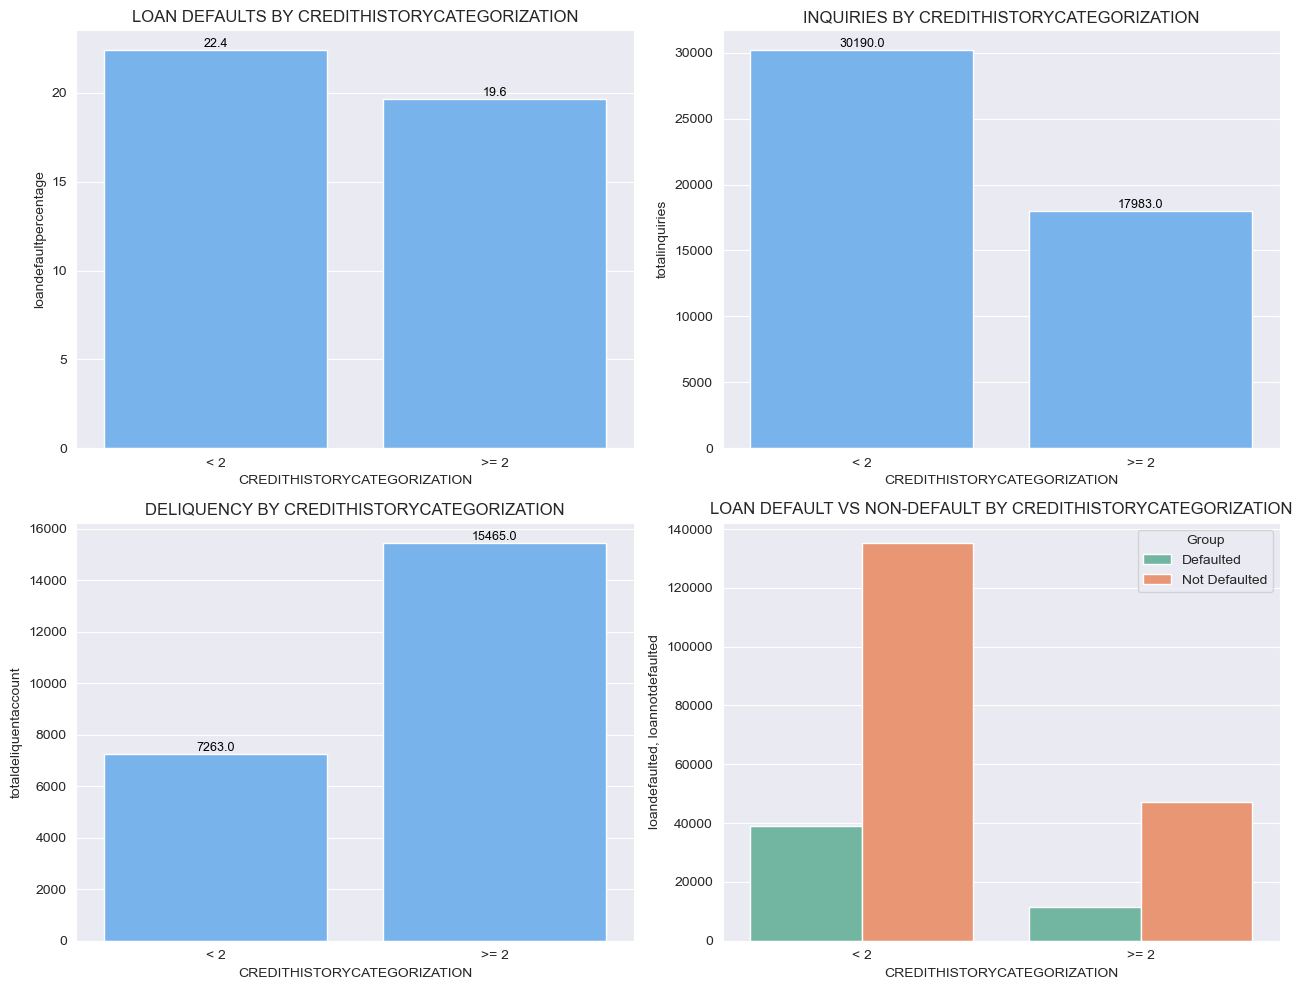

In [43]:
chartParams = {
    "chartData": [
       {
            "type": "bar",  # Simple bar chart
            "xCol": "credithistorycategorization",  # States as the x-axis
            "yCol": ["loandefaultpercentage"],  # Loan defaults as the y-axis
            "chartTitle": "Loan Defaults by credithistorycategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Simple bar chart
            "xCol": "credithistorycategorization",  # States as the x-axis
            "yCol": ["totalinquiries"],  # Loan defaults as the y-axis
            "chartTitle": "Inquiries by credithistorycategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Simple bar chart
            "xCol": "credithistorycategorization",  # States as the x-axis
            "yCol": ["totaldeliquentaccount"],  # Loan defaults as the y-axis
            "chartTitle": "Deliquency by credithistorycategorization",
            "legend": None  # Simple bar chart without grouping
        },
        {
            "type": "bar",  # Grouped bar chart
            "xCol": "credithistorycategorization",  # States as the x-axis
            "yCol": ["loandefaulted", "loannotdefaulted"],  # Multiple y-columns for grouped bars
            "chartTitle": "Loan Default vs Non-default by credithistorycategorization",
            "legend": ["Defaulted", "Not Defaulted"]  # Custom legend labels for grouping
        },
    ]
}
plotTwoCharts(data, chartParams)

### **Credit History Categorization:**

- **Default Rate:** Higher default percentage for < 2 years of credit history (22.40%) vs. >= 2 years (19.64%).
- **Inquiries:** More loan inquiries for < 2 years (23,190) than >= 2 years (17,983).
- **Delinquent Accounts:** More delinquent accounts for >= 2 years (15,465) than < 2 years (7,263).




### **Insights**
- **Higher Risk:** Shorter credit history and account age correlate with higher loan defaults.
- **Increased Inquiries:** Newer accounts tend to have more loan inquiries.

## **Closure Statement :**

- **High Risk Categories (M, K, L) show higher loan default rates (30.46%, 27.81%, 28.04%).**
- **Low Risk Categories (A, B) have lower default rates (13.13% to 16.57%).**
- **Not Scored Categories show higher defaults (25.58%).**
- **State_ID 12 has the highest default rate (30.7%) and the largest disparity between defaulted and non-defaulted loans.**
- **LTV Analysis shows a peak default rate at 26.6% for the highest LTV category, with an increasing trend across quarters.**
- **Account Age: Loans with < 1 year show higher defaults (22.28%) compared to >= 1 year (20.21%).**
- **Credit History: Loans with < 2 years of history have higher defaults (22.40%) compared to >= 2 years (19.64%).**

#### **These findings highlight critical areas for improving risk management and decision-making processes.**